In [1]:
# colab example https://colab.research.google.com/drive/12zBvL0v0qZHbpSGXLLjHfQ0w6OZOVHaB#scrollTo=KhLt6VA3wvCB
# github https://github.com/MilaNLProc/contextualized-topic-models#preprocessing
# prodLDA https://arxiv.org/pdf/1703.01488.pdf
# neural prodLDA + specter embedding rep article https://arxiv.org/pdf/2004.03974v1.pdf

## Overview
#### Combine pre-trained representations (from SPECTER)and neural topic model (neural prodLDA) = Contextualized Topic Model (CTM). Most topic models still use Bag of Words (BoW) document representations as model input, rather than contextualized representations. BoW representations do not account for syntactic and semantic relationships among the words in a document.

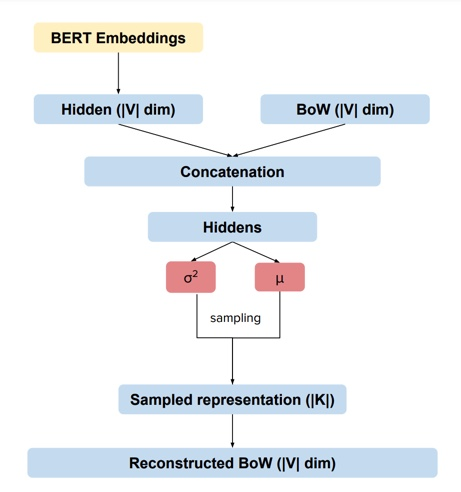

In [2]:
%%capture
# !pip install contextualized-topic-models==1.8.1
!pip install sentence-transformers
!pip install torch==1.6.0+cu101 torchvision==0.7.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

### Import files from Google Drive

In [4]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [5]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
%cd /content/drive/MyDrive/contextualized-topic-models-master

/content/drive/MyDrive/contextualized-topic-models-master


### Import libaries and functions

In [74]:
from contextualized_topic_models.models.ctm import CombinedTM, ZeroShotTM
from contextualized_topic_models.utils.data_preparation import bert_embeddings_from_file, TopicModelDataPreparation
from contextualized_topic_models.utils.preprocessing import WhiteSpacePreprocessing
from contextualized_topic_models.datasets.dataset import CTMDataset
from contextualized_topic_models.evaluation.measures import CoherenceNPMI, InvertedRBO
import gensim
from gensim.corpora.dictionary import Dictionary
from gensim.models import ldamodel 
import os
import numpy as np
import pickle
import pandas as pd
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Read our data files and store the documents as lists of strings

In [11]:
# MODEL DATA CATALOG ABSTRACT DATA:
df = pd.read_csv('abstracts.csv')
df["title_text"] = df["Title"] + ' ' + df["Text"]
wp = WhiteSpacePreprocessing(df.title_text)
text_training_preprocessed, text_training_not_preprocessed, vocab_list = wp.preprocess()

### NOTE: Make sure that the lenghts of the two lists of documents are the same and the index of a not preprocessed document corresponds to the index of the same preprocessed document.

In [12]:
print(len(text_training_preprocessed) == len(text_training_not_preprocessed))

True


## Split into train/test

In [13]:
training_bow_documents = text_training_preprocessed[0:38]
training_contextual_document = text_training_not_preprocessed[0:38]

testing_bow_documents = text_training_preprocessed[38:]
testing_contextual_documents = text_training_not_preprocessed[38:]

## Create the training set

In [14]:
#uncomment to use regular BERT
# tp = TopicModelDataPreparation("bert-base-nli-mean-tokens")

# Using SPECTER from ALLENAI
tp = TopicModelDataPreparation("allenai-specter")

In [15]:
training_dataset = tp.create_training_set(training_contextual_document, training_bow_documents)

#### Let's check the vocabulary

In [16]:
tp.vocab[:10]

['ability',
 'absence',
 'acceleration',
 'accepted',
 'acceptor',
 'acceptors',
 'access',
 'accommodates',
 'account',
 'accounted']

In [17]:
# #TODO check BERT input size
# ctm = CombinedTM(input_size=len(tp.vocab), bert_input_size=768, num_epochs=200, num_topics=9, model_type='prodLDA',
#                  hidden_sizes=(100, 100), activation='softplus', dropout=0.2,
#                  learn_priors=True, batch_size=10, lr=2e-2, momentum=0.99,
#                  solver='adam', reduce_on_plateau=True, num_data_loader_workers=4)
# ctm.fit(training_dataset) 

In [18]:
#TODO check BERT input size
ctm = ZeroShotTM(input_size=len(tp.vocab), bert_input_size=768, num_epochs=250, num_topics=9, model_type='prodLDA',
                 hidden_sizes=(100, 100), activation='softplus', dropout=0.2,
                 learn_priors=True, batch_size=10, lr=2e-2, momentum=0.99,
                 solver='adam', reduce_on_plateau=True, num_data_loader_workers=4)
ctm.fit(training_dataset)

Epoch: [200/200]	 Seen Samples: [7600/7600]	Train Loss: 888.6072162828947	Time: 0:00:00.305159: : 200it [01:02,  3.21it/s]


## Get topics list

In [19]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [20]:
ctm.get_topics(5)

defaultdict(list,
            {0: ['equations',
              'aquifer',
              'reactions',
              'saltwater',
              'difference'],
             1: ['transport', 'model', 'coastal', 'modeling', 'ocean'],
             2: ['hydrodynamics',
              'flooding',
              'called',
              'coral',
              'hydrodynamic'],
             3: ['vegetation',
              'managers',
              'occurrence',
              'aquatic',
              'predicted'],
             4: ['integrating', 'crop', 'lsp', 'rainfed', 'phenology'],
             5: ['full', 'sensitive', 'lpf', 'body', 'rewetting'],
             6: ['programs', 'stability', 'fortran', 'rainfall', 'simple'],
             7: ['thermodynamic', 'complete', 'version', 'major', 'waters'],
             8: ['stream', 'streamflow', 'permanence', 'channel', 'models']})

## Look at a word cloud

In [21]:
%%capture
pip install matplotlib==3.1.3

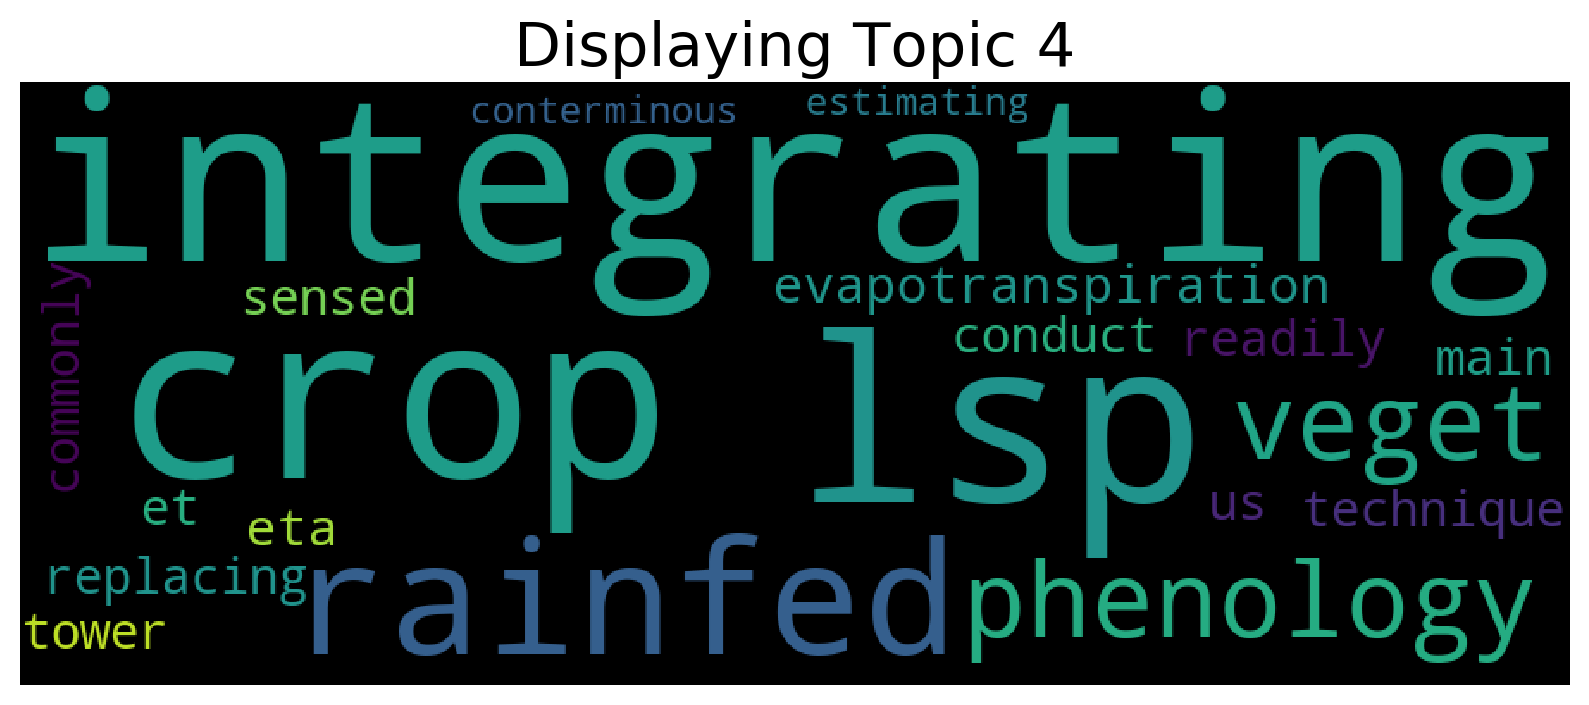

In [22]:
ctm.get_wordcloud(topic_id=0, n_words=20)

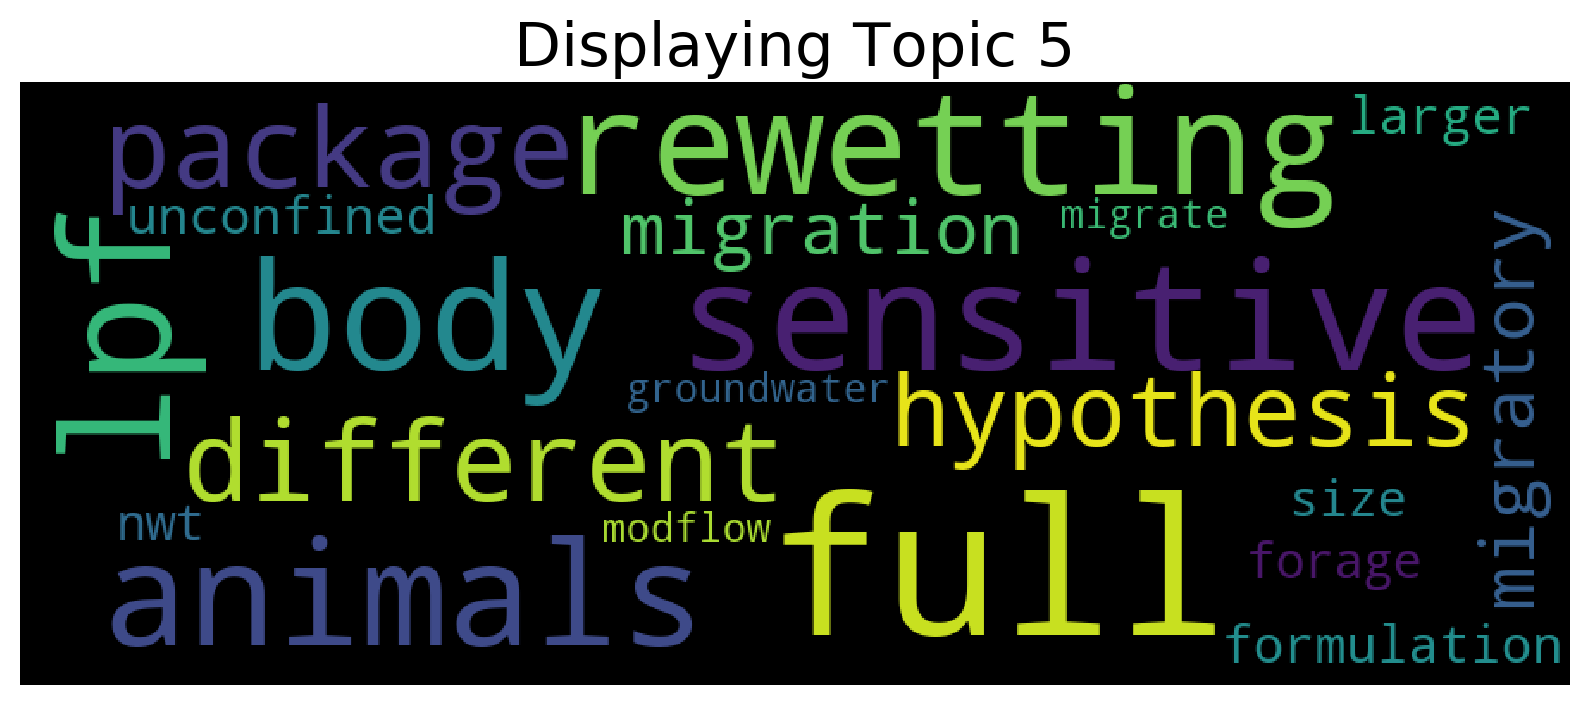

In [23]:
ctm.get_wordcloud(topic_id=1, n_words=20)

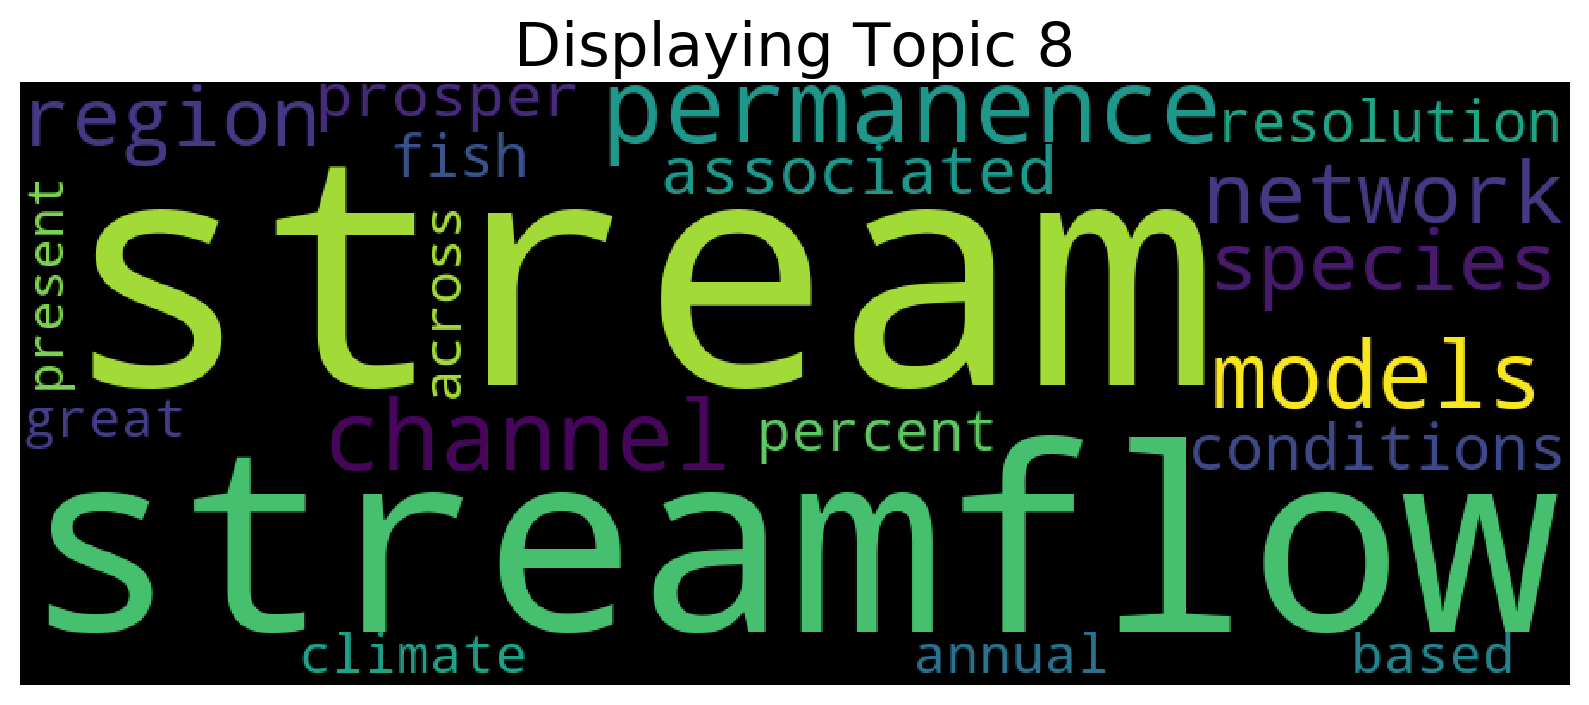

In [24]:
ctm.get_wordcloud(topic_id=2, n_words=20)

## Use the test set

In [25]:
testing_dataset = tp.create_test_set(testing_contextual_documents, testing_bow_documents) # create dataset for the testset
# print(testing_dataset[0])

In [26]:
predictions = ctm.get_doc_topic_distribution(testing_dataset)

Sampling: [5/5]: : 5it [00:01,  3.25it/s]

2
9


In [27]:
#Select the test_document to view:
selected_doc = 0

print('probability for each topic', predictions[selected_doc])
print()
topic_index = np.argmax(predictions[selected_doc])
print('arg_max:', topic_index)
print()
print('original text:', testing_contextual_documents[selected_doc][0:350])
print()
print('topic_keywords:', ctm.get_topics(5)[topic_index])
# print(ctm.get_word_distribution_by_topic_id(topic_index)[0:20])

probability for each topic [0.06018319 0.02113591 0.04711569 0.07899376 0.22127261 0.12712356
 0.31375025 0.06184425 0.06858076]

arg_max: 6

original text: Scoops3D: software to analyze 3D slope stability throughout a digital landscape The computer program, Scoops3D, evaluates slope stability throughout a digital landscape represented by a digital elevation model (DEM). The program uses a three-dimensional (3D) method of columns approach to assess the stability of many (typically millions) potential l

topic_keywords: ['programs', 'stability', 'fortran', 'rainfall', 'simple']


In [28]:
pt = ctm.get_predicted_topics(testing_dataset, n_samples=2)
print(pt)

Sampling: [1/1]: : 1it [00:00,  3.17it/s]

2
9
[6, 1]


## Evaluate the model

## LDA

#### We are going to use gensim's LDA implementation and the preprocessed text to learn topics from the abstracts for comparison

In [29]:
lda_text = list(map(lambda x : x.split(), training_bow_documents))

id2word = Dictionary(lda_text)
texts = lda_text
corpus = [id2word.doc2bow(text) for text in texts]

lda_model = ldamodel.LdaModel(
   corpus=corpus, id2word=id2word, num_topics=9, passes=10, alpha='auto', per_word_topics=True, iterations=200)

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

In [30]:
lda_topics = []
for i in range(9):
    t = [w[0] for w in lda_model.show_topic(i)[0:10]]
    lda_topics.append(t)

In [31]:
lda_topics[0]

['model',
 'transport',
 'flow',
 'water',
 'hydraulic',
 'well',
 'quality',
 'simulated',
 'system',
 'conductivity']

## coherence score

In [32]:
#LDA topics
npmi = CoherenceNPMI(texts=texts, topics=lda_topics)
npmi.score()

-0.08778680162321535

In [33]:
#Combine topic score
npmi = CoherenceNPMI(texts=texts, topics=ctm.get_topic_lists(10))
npmi.score()

['equations', 'aquifer', 'reactions', 'saltwater', 'difference', 'linear', 'sharp', 'finite', 'oteq', 'analytical']
['transport', 'model', 'coastal', 'modeling', 'ocean', 'oteq', 'grid', 'coupling', 'wave', 'results']
['hydrodynamics', 'flooding', 'called', 'coral', 'hydrodynamic', 'essential', 'bed', 'forcing', 'coasts', 'use']
['vegetation', 'managers', 'occurrence', 'aquatic', 'predicted', 'variables', 'level', 'submersed', 'predict', 'water']
['integrating', 'crop', 'lsp', 'rainfed', 'phenology', 'veget', 'evapotranspiration', 'eta', 'us', 'sensed']
['full', 'sensitive', 'lpf', 'body', 'rewetting', 'animals', 'package', 'different', 'hypothesis', 'migration']
['programs', 'stability', 'fortran', 'rainfall', 'simple', 'tutorial', 'unsaturated', 'safety', 'materials', 'program']
['thermodynamic', 'complete', 'version', 'major', 'waters', 'fluid', 'microcomputer', 'trace', 'base', 'relation']
['stream', 'streamflow', 'permanence', 'channel', 'models', 'network', 'species', 'region', '

-0.11831731824005359

## pyLDAvis

In [34]:
%%capture
!pip install pyLDAvis==3.3.1

In [35]:
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_lda.py:29: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps


In [36]:
# https://github.com/bmabey/pyLDAvis/blob/master/notebooks/Gensim%20Newsgroup.ipynb 
vis_data = gensimvis.prepare(lda_model, corpus, id2word)
pyLDAvis.display(vis_data)

In [37]:
from gensim import models

hdp = models.hdpmodel.HdpModel(corpus, id2word, T=9)
vis_data = gensimvis.prepare(hdp, corpus, id2word)
pyLDAvis.display(vis_data)

/usr/local/lib/python3.7/dist-packages/gensim/models/hdpmodel.py:459: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  start_time = time.clock()


In [85]:
# topic_dist = ctm.get_topic_distribution(training_dataset)

topic_dist = ctm.get_doc_topic_distribution(training_dataset)

Sampling: [20/20]: : 20it [00:06,  2.99it/s]

38
9


In [86]:
topic_dist = topic_dist.tolist()
topic_dist = gensim.matutils.corpus2dense(topic_dist, 30).T

/usr/local/lib/python3.7/dist-packages/gensim/matutils.py:502: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  result = np.column_stack(sparse2full(doc, num_terms) for doc in corpus)


TypeError: ignored

In [70]:
# topic_dist = topic_dist.T
# s = topic_dist.sum(axis=0)
# print(s.shape)
# topic_dist = topic_dist / s
topic_dist = topic_dist / topic_dist.sum(axis=1)
print(topic_dist.shape)

AttributeError: ignored

In [68]:
isinstance(topic_dist, list)

True

In [39]:
vis_data = gensimvis.prepare(ctm, corpus, id2word, doc_topic_dist=topic_dist)
pyLDAvis.display(vis_data)

# TODO AttributeError: 'CombinedTM' object has no attribute 'inference'

# see inference for hdp online 212
# https://github.com/largelymfs/topical_word_embeddings/blob/master/TWE-2/gensim/models/hdpmodel.py 

# gamma (parameters controlling the topic weights) for each document
# gamma is of shape len(chunk) x self.num_topics

# see inference for ldp on line 631
# https://github.com/RaRe-Technologies/gensim/blob/develop/gensim/models/ldamodel.py

# spent a while on this problem, trying to figure out the equivalent to inference from lda or hdp for neural prod-lda
# also has CTM class and CombinedTM(CTM)



ValueError: ignored

In [ ]:
# data = pyLDAvis.prepare(topic_term_dists, doc_topic_dists, doc_lengths, vocab, term_frequency, R=30, lambda_step=0.01, sort_topics=True)
# # topic_term_dists: Matrix of topic-term probabilities
# # doc_topic_dists: Matrix of document-topic probabilities.
# # doc_lengths: The length of each document, i.e. the number of words in each document. The order of the numbers should be consistent with the ordering of the docs in doc_topic_dists.
# # vocab: List of all the words in the corpus used to train the model.
# # term_frequency: The count of each particular term over the entire corpus. The ordering of these counts should correspond with vocab and topic_term_dists.
# # R=30: The number of terms to display in the barcharts of the visualization. Default is 30. Recommended to be roughly between 10 and 50.
# pyLDAvis.display(data)